In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!pip install imageio==2.4.1
!pip install gym[toy_text]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colabgymrender: filename=colabgymrender-1.1.0-py3-none-any.whl size=3131 sha256=24b84877213601016f2815ee674e8200f72b22bdb925612befed9bd2ec5e7b46
  Stored in directory: /root/.cache/pip/wheels/f1/0a/2a/86955ea711b461ab7918236fed2568733f75ed677d0524b56c
Successfully built colabgymrender
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 27.8 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=e101cdb40f5ccc54e8a912482e45d0714817dc29255bb6b250324380e29d91f4
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-

In [ ]:
# Setup Environment
import gym
from colabgymrender.recorder import Recorder
from typing import List, Set, Dict, Tuple, Optional
import numpy as np
from tqdm import tqdm
import os 
import numpy.ma as ma
from numpy.core.getlimits import inf
from collections import defaultdict
from gym.spaces import Space, Discrete
import random 
import matplotlib.pyplot as plt
import sys

os.environ["SDL_VIDEODRIVER"] = "dummy"

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)3858432/45929032 bytes (8.4%)7749632/45929032 bytes (16.9%)11829248/45929032 bytes (25.8%)15499264/45929032 bytes (33.7%)19587072/45929032 bytes (42.6%)23707648/45929032 bytes (51.6%)27680768/45929032 bytes (60.3%)31490048/45929032 bytes (68.6%)34398208/45929032 bytes (74.9%)37224448/45929032 bytes (81.0%)40984576/45929032 bytes (89.2%)45096960/45929032 bytes (98.2%)

In [ ]:
class Agent(object):
  def __init__(self, state_space: Space, action_space: Space, discount_rate: float):
    self._state_spacee = state_space
    self._action_space = action_space
    self._discount_rate = discount_rate
    self._prev_action = None
    self._prev_state = None

In [ ]:
# Utils
def get_epsilon_greedy_policy_from_action_values(action_values : np.array, epsilon: Optional[float] = 0.0) -> np.array:
  optimal_actions = np.argmax(action_values, axis=-1)
  num_actions = action_values.shape[-1]
  policy = np.full(action_values.shape, epsilon / num_actions)
  if optimal_actions.ndim == 0:
    policy[optimal_actions] += 1.0 - epsilon
  elif optimal_actions.ndim == 1:
    for i, j in enumerate(optimal_actions):
      policy[i, j] += 1.0 - epsilon
  else:
    raise NotImplementedError
  return policy

def get_state_values_from_action_values(action_values : np.array, policy: Optional[np.array] = None) -> np.array:
  if policy is None:
    #assume greedy policy
    policy = get_epsilon_greedy_policy_from_action_values(action_values)
  state_values = np.sum(action_values * policy, axis=1)
  return state_values

def plot_history(history: list):
  plt.figure(0, figsize=(16,4))
  plt.title("average reward per step")
  history_smoothed = [np.mean(history[max(0, i-max_episode//10): i+1]) for i in range(len(history))]
  plt.plot(history)
  plt.plot(history_smoothed)


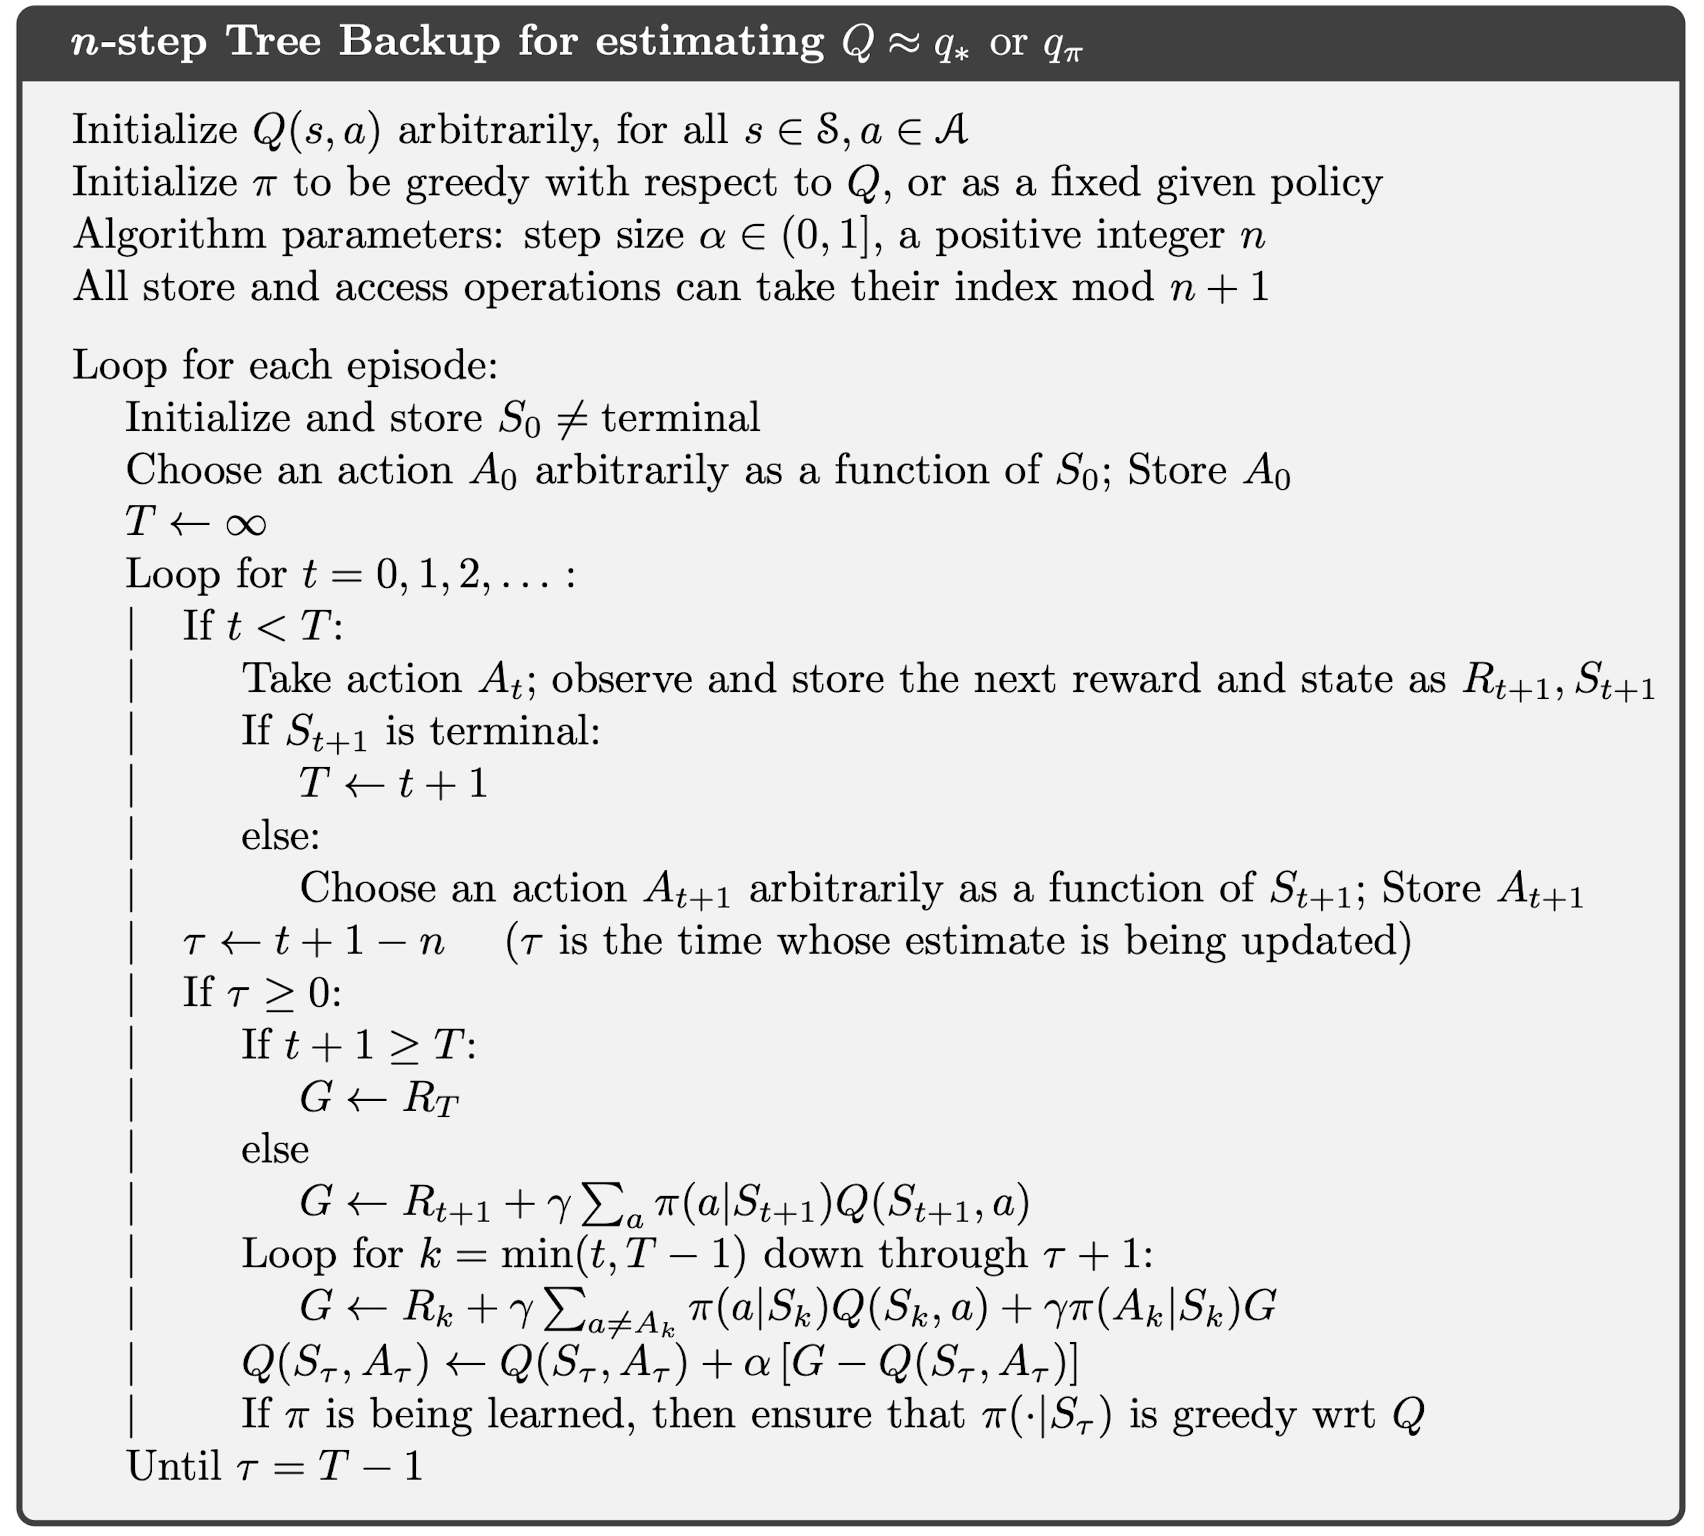

In [ ]:
class nStepTreeBackupAgent(Agent):
  def __init__(self, state_space: Discrete, action_space: Discrete, discount_rate: float, epsilon:float, step_size:float, n:int):
    super().__init__(state_space, action_space, discount_rate) 
    self._epsilon = epsilon
    self._step_size = step_size 
    self._n = n
    # action values
    self._Q = np.random.rand(state_space.n, action_space.n) #np.full((state_space.n, action_space.n), 0.0) 
    # policy
    self._behavior_policy = get_epsilon_greedy_policy_from_action_values(self._Q, self._epsilon)
    self._target_policy = get_epsilon_greedy_policy_from_action_values(self._Q)
    self.reset()

  def reset(self):
    self._actions = []
    self._states = []
    self._rewards = [0.0]

  def sample_action(self, state, policy_name: str) -> int:
    if policy_name == 'behavior':
      policy = self._behavior_policy
    elif policy_name == 'target':
      policy = self._target_policy
    else:
      raise NotImplemented
    action = np.random.choice(len(policy[state]), p = policy[state])
    self._actions.append(action)
    return action 

  def record(self, state, reward: Optional[int] = None):
    self._states.append(state)
    if reward is not None:
      self._rewards.append(reward)
  
  def control(self, t: int, T: int):
    n = self._n
    # state that is visited at time step tao will be updated (it's n step before t)
    tao = t - n + 1
    if tao >= 0:
      # calculate returns G
      ## Step 1: caculate end of step return (step t+1)
      if t + 1 >= T:
        G = self._rewards[T]
      else:
        # return of the last step = reward + all future returns dicounted
        G = self._rewards[t+1] + self._discount_rate * np.sum(self._target_policy[self._states[t+1]] * self._Q[self._states[t+1]])
      ## Step 2: recursively calculate returns backward from step t -> tao+1
      for k in range(min(t, T-1), tao+1, -1):
        leaves = 0
        # suming up the expected return from leaf nodes that wasn't taken at step k
        for i in range(self._action_space.n):
          if i != self._actions[k]:
            leaves += self._target_policy[self._states[k], i] * self._Q[self._states[k], i]
        # add returns from nodes that was taken at step k
        G = self._rewards[k] + self._discount_rate * (leaves + G * self._target_policy[self._states[k], self._actions[k]])
      # update Q value 
      self._Q[self._states[tao], self._actions[tao]] += self._step_size * (G - self._Q[self._states[tao], self._actions[tao]])
      # update policy of updated state 
      self._target_policy[self._states[tao]] = get_epsilon_greedy_policy_from_action_values(self._Q[self._states[tao]]) 
      self._behavior_policy[self._states[tao]] = get_epsilon_greedy_policy_from_action_values(self._Q[self._states[tao]], self._epsilon) 
    return tao == T-1

def test_n_step_tree_backup_agent():
  np.random.seed(0)
  agent = nStepTreeBackupAgent(
    state_space=Discrete(4), 
    action_space=Discrete(4), 
    discount_rate=1.0,
    epsilon=0.2,
    step_size=1.0,
    n=1
  )
  agent._states = [0, 0]
  agent._actions = [0, 1]
  agent._rewards = [0,2]
  tao = 0
  G = agent._rewards[1] + agent._discount_rate * agent._Q[0, 1]
  Q = agent._Q[0,0] 
  Q += agent._step_size * (G - Q)
  done = agent.control(0,10)
  np.testing.assert_equal(Q, agent._Q[0,0])

  print("test_n_step_tree_backup_agent passed!")
  
test_n_step_tree_backup_agent() 

test_n_step_tree_backup_agent passed!


In [ ]:
def play_episode(agent: Agent, env: gym.Env, policy_type: str):
  state = env.reset()
  agent.reset()
  agent.record(state)
  t = 0
  T = sys.maxsize
  action = agent.sample_action(state, policy_type)
  stop = False
  while not stop:
    if t < T: 
      new_state, reward, terminal, info = env.step(action)
      agent.record(new_state, reward)
      if terminal:
        T = t + 1
      else:
        action = agent.sample_action(new_state, policy_type)
    stop = agent.control(t, T)
    t += 1
  
  return reward, T-1


  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."

See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "

  0%|          | 1/1000 [00:00<10:09,  1.64it/s]

step 0, total reward 0.0, efficiency 0.0


 10%|█         | 101/1000 [00:38<05:07,  2.93it/s]

step 100, total reward 0.0, efficiency 0.0


 20%|██        | 202/1000 [01:01<03:11,  4.16it/s]

step 200, total reward 30.0, efficiency 0.034482758620689655


 30%|███       | 301/1000 [01:22<01:37,  7.16it/s]

step 300, total reward 89.0, efficiency 0.0


 40%|████      | 401/1000 [01:41<02:41,  3.72it/s]

step 400, total reward 157.0, efficiency 0.0


 50%|█████     | 501/1000 [02:09<03:05,  2.70it/s]

step 500, total reward 204.0, efficiency 0.0


 60%|██████    | 603/1000 [02:35<00:48,  8.21it/s]

step 600, total reward 250.0, efficiency 0.015384615384615385


 70%|███████   | 703/1000 [02:56<00:35,  8.38it/s]

step 700, total reward 312.0, efficiency 0.05555555555555555


 80%|████████  | 802/1000 [03:16<00:40,  4.85it/s]

step 800, total reward 370.0, efficiency 0.0


 90%|█████████ | 901/1000 [03:38<00:23,  4.29it/s]

step 900, total reward 431.0, efficiency 0.012345679012345678


100%|██████████| 1000/1000 [04:06<00:00,  4.05it/s]
  result = np.fromstring(s, dtype='uint8')




rewarding episodes: 461.0


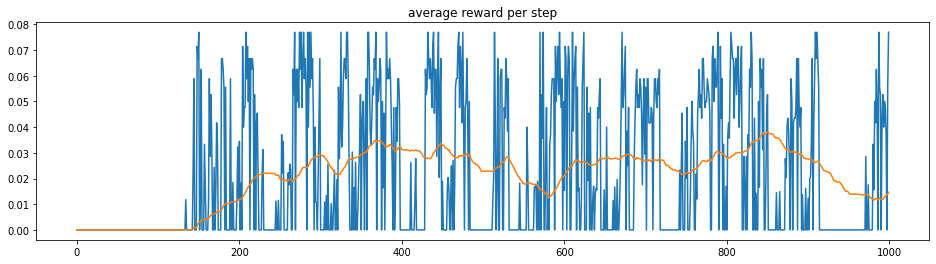

In [ ]:
### Off policy learning ###
# Create Environment.
#env = gym.make('Taxi-v3')
reset_agent = True
env = gym.make('FrozenLake-v1', desc=None, map_name="8x8", is_slippery=False)
directory = './video'
env = Recorder(env, directory)
if reset_agent:
  agent = nStepTreeBackupAgent(
    state_space=env.observation_space, 
    action_space=env.action_space, 
    discount_rate=0.9,
    epsilon=0.2,
    step_size=0.5,
    n = 30
  )
  history = []
  total_reward = 0

# start playing
max_episode = 1000
for i in tqdm(range(max_episode)):
  reward, steps = play_episode(agent, env, 'behavior')
  history.append(reward / steps)
  total_reward += reward
  if i % 100 == 0:
    print(f"step {i}, total reward {total_reward}, efficiency {history[-1]}")


print(f"\nrewarding episodes: {total_reward}")
plot_history(history)

play_episode(agent, env, 'target')
env.play()


[[b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'DOWN']
 [b'DOWN' b'UP' b'UP' b'RIGH' b'UP' b'DOWN' b'LEFT' b'DOWN']
 [b'RIGH' b'UP' b'LEFT' b'DOWN' b'RIGH' b'RIGH' b'DOWN' b'DOWN']
 [b'RIGH' b'RIGH' b'RIGH' b'RIGH' b'UP' b'UP' b'DOWN' b'DOWN']
 [b'UP' b'LEFT' b'UP' b'LEFT' b'UP' b'RIGH' b'RIGH' b'DOWN']
 [b'UP' b'DOWN' b'LEFT' b'RIGH' b'DOWN' b'UP' b'DOWN' b'DOWN']
 [b'DOWN' b'UP' b'DOWN' b'LEFT' b'DOWN' b'UP' b'LEFT' b'DOWN']
 [b'DOWN' b'DOWN' b'UP' b'RIGH' b'RIGH' b'LEFT' b'UP' b'RIGH']]


Text(0.5, 1.0, 'state_values')

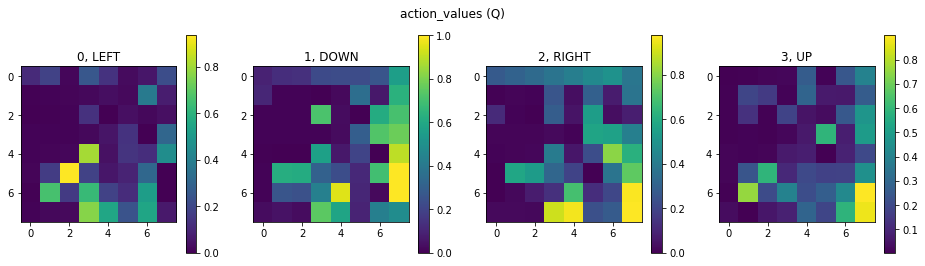

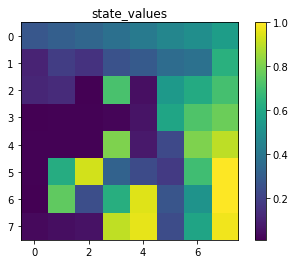

In [ ]:
# Plot the action values.
# cliff walking
#shape = (4,12,4)
# frozen lake
## small
#shape = (4,4,4)
## large
shape = (8,8,4)
direction = {
  0:"LEFT",
  1:"DOWN",
  2:"RIGHT",
  3:"UP"
}
actions = np.argmax(agent._target_policy, axis=1)
actions = actions.reshape(shape[:2])
named_actions = np.chararray(actions.shape, itemsize=4)
map = [[""] * shape[1]] * shape[0]
for idx, val in np.ndenumerate(actions):
  named_actions[idx] = direction[val]
  #map[idx[0]][idx[1]] = direction[val]
print(named_actions)

action_values = agent._Q.reshape(shape)
num_actions = action_values.shape[-1]
plt.figure(2, figsize=(16,4))
plt.suptitle("action_values (Q)")
for i in range(num_actions):
  plt.subplot(1, num_actions,i+1)
  plt.title(f"{i}, {direction[i]}")
  plt.imshow(action_values[:,:,i])
  plt.colorbar(orientation='vertical')
  #print(action_values[:,:,i])


plt.figure(3)
state_values = get_state_values_from_action_values(agent._Q, agent._target_policy)
plt.imshow(state_values.reshape(shape[:2]))
plt.colorbar(orientation='vertical')
plt.title("state_values")


# Summary

## Temporal Difference on policy learning 
Temporal difference combines Monte Carlo with dynamic programming.
```
V(s) = V(s) + learning_rate * (reward + discount_rate * V(s') - V(s))
```
The last part is also called TD-error:
```
td_error = (reward + discount_rate * V(s') - V(s))
```

### Sarsa
Sarsa requires `(state, action, reward, next_state, next_action)` to update action_values `_Q` and use that to create a epsilon-greedy policy `_policy`.

What makes it on-policy learning is that fact that `next_action` is both 
1. the action the agent is taking  -> behavior policy
2. the action the agent is using to update the action values `_Q` (policy evluation) -> target policy

The conflict is that 1 requires exploration to learn from unexplored environment. But 2 is affected by such exploration (because next action will not always be the optimal one, affecting the value of `_Q`). 


